In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("heart.csv")

In [37]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
numeric_df = df.select_dtypes(np.number)
scaled_features = StandardScaler().fit_transform(numeric_df.values)
scaled_df = pd.DataFrame(scaled_features, columns=numeric_df.columns)

In [4]:
cat_df = df.select_dtypes(exclude=np.number)
dummy_df = pd.get_dummies(
    cat_df, drop_first=True
)  # Drop first dummy variable as a base

In [5]:
features = pd.concat([scaled_df, dummy_df], axis=1)
features["HeartDisease"] = df[
    "HeartDisease"
]  # Undo standard scaling for target variable

In [6]:
x = features.drop(columns=["HeartDisease"])
y = features["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

## Discriminant Analysis (LDA/QDA)

In [18]:
# LDA
# Start with solver
grid = {'solver': ['svd', 'lsqr', 'eigen']}

lda_mod = LinearDiscriminantAnalysis()
clf = GridSearchCV(lda_mod, param_grid=grid, scoring='roc_auc', cv=10, n_jobs=-1)
best_lda = clf.fit(X_train, y_train)

# SVD is best solver, so no shrinkage tuning required
print(best_lda.best_estimator_.get_params())

{'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}


In [19]:
# roc_auc = .887, accuracy = .88
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       109
           1       0.93      0.87      0.90       167

    accuracy                           0.88       276
   macro avg       0.88      0.89      0.88       276
weighted avg       0.89      0.88      0.88       276

0.8866670329066637


In [17]:
# QDA
qda_mod = QuadraticDiscriminantAnalysis()
qda_mod.fit(X_train, y_train)

# roc_auc = .879, accuracy = .87
y_pred = qda_mod.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       109
           1       0.93      0.85      0.89       167

    accuracy                           0.87       276
   macro avg       0.87      0.88      0.87       276
weighted avg       0.88      0.87      0.87       276

0.879278140965775


## SVM

In [10]:
# SVM
svm_mod = SVC()

grid = {
    'C': [.01, .1, 1, 10],
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'gamma': ['auto', 10, 1, .1, .01, .001]
}

# grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

clf_svm = GridSearchCV(svm_mod, param_grid=grid, scoring='roc_auc', cv=10, n_jobs=-1, verbose=2)
best_svm = clf_svm.fit(X_train, y_train)
print(best_svm.best_estimator_.get_params())

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:    8.9s


{'C': 10, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   10.9s finished
/Users/sam/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [16]:
# roc_auc = .877, accuracy = .88
y_pred = clf_svm.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       109
           1       0.91      0.89      0.90       167

    accuracy                           0.88       276
   macro avg       0.87      0.88      0.88       276
weighted avg       0.88      0.88      0.88       276

0.8773004449815964


## XGBoost

In [12]:
# XGBoost
xgb_mod = XGBClassifier()

dist = {
        'eta': [0.01, 0.05, 0.1, 0.2, 0.3],
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.1, 0.5, 1.0, 5, 10],
        'subsample': np.arange(0.5, 1, 0.1),
        'colsample_bytree': np.arange(0.5, 1, 0.1),
        'max_depth': np.arange(3, 10, 2),
        'scale_pos_weight': [1, 1.2],
        'reg_alpha': [0, 0.1, 1.0, 10.0, 100.0],
        'reg_lambda': [0, 0.1, 1.0, 10.0, 100.0]
        }

clf_xgb = RandomizedSearchCV(xgb_mod, param_distributions=dist, scoring='roc_auc', n_iter=50000, cv=10, random_state=1, n_jobs=-1, verbose=2)
best_xgb = clf_xgb.fit(X_train, y_train)
print(best_xgb.best_estimator_.get_params())

Fitting 10 folds for each of 50000 candidates, totalling 500000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 9105 tasks      | 

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8999999999999999, 'gamma': 0.5, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 5, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'scale_pos_weight': 1.2, 'seed': None, 'silent': None, 'subsample': 0.8999999999999999, 'verbosity': 1, 'eta': 0.2}


In [22]:
# Model with highest roc_auc
xgb_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bytree=0.6,
gamma=1, learning_rate=0.1, max_delta_step=0, max_depth=9, min_child_weight=5, missing=None, n_estimators=100,
n_jobs=1, nthread=None, objective='binary:logistic', random_state=0, reg_alpha=10, reg_lambda=0.1,
scale_pos_weight=1.2, subsample=0.9, eta=0.2)
xgb_model.fit(X_train, y_train)

# roc_auc = .891, accuracy = .90
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       109
           1       0.91      0.93      0.92       167

    accuracy                           0.90       276
   macro avg       0.90      0.89      0.89       276
weighted avg       0.90      0.90      0.90       276

0.890677360874581


In [65]:
feature_names = features.columns.tolist()
feature_names.remove('HeartDisease')

plot_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
})

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

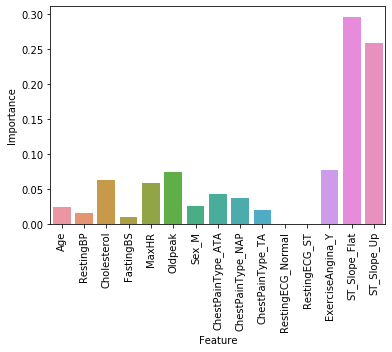

In [67]:
sns.barplot(x = 'Feature', y = 'Importance', data=plot_df)
plt.xticks(rotation=90)

In [79]:
recall_list = []
for thresh in np.arange(1, 0, -0.01):
    y_rec_p = xgb_model.predict_proba(X_test)
    y_rec_p = [1 if item[1] > thresh else 0 for item in y_rec_p]
    recall_list.append(recall_score(y_test, y_rec_p))

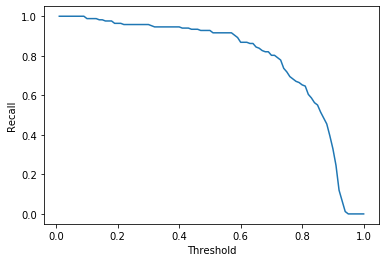

In [81]:
plot_recall = pd.DataFrame({
    'Threshold': np.arange(1, 0, -0.01),
    'Recall': recall_list
    })

sns.lineplot(x = 'Threshold', y = 'Recall', data = plot_recall)